# OCR latex

**Цель проекта:** сравнить несколько предобученных моделей для задачи распознания математических формул по изображению с выдачей результата в виде LaTeX кода.

**Метрика:**
- **[CER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/char_error_rate.html) (Char Error Rate)** $= \frac{S + D + I}{N} = \frac{S + D + I}{S + D + C}$, где
    - **S** is the number of substitutions,
    - **D** is the number of deletions,
    - **I** is the number of insertions,
    - **C** is the number of correct characters,
    - **N** is the number of characters in the reference ($N=S+D+C$).

ps: большинство функций, используемых в проекте, вынесены в отдельные `*.py` файлы.

## Imports

In [1]:
import re
import random
from pathlib import Path
from collections.abc import Callable
from typing import Any
from termcolor import colored

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
import albumentations as A
from doctr import transforms as T

from transformers import VisionEncoderDecoderModel, NougatProcessor, VisionEncoderDecoderConfig
from transformers.models.nougat import NougatTokenizerFast
from nougat_latex import NougatLaTexProcessor

from transformers import logging
logging.set_verbosity_error()

from torchmetrics.text import CharErrorRate
from torchmetrics.functional.text import char_error_rate

from utils import (
    torch_device,
    DeNormalize, 
    Ansi,
    write_json, 
    read_json, 
    highlight_diff,
    process_raw_latex, 
    latex2pil,
    draw_random_images,
    draw_random_images_torchset,
)
from images import ColorShiftAlb, edit_images
from mydataset import NougatDataset
from experiment import show_predicts
from mymetrics import AccTokenMetric
from im2latex100k_preprocess import Im2LatexPreprocess

# import os
# os.environ['PYTORCH_HIP_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
SEED = 42

DATASET = Path('dataset/im2latex')

IS_CUDA = torch.cuda.is_available()
DEVICE = torch_device()

torch use: cuda (AMD Radeon RX 7800 XT)


In [3]:
# print(torch.cuda.memory_summary())

## Dataset

### dataset I

В качестве датасета для обучения и тестирования возьмем **[im2latex-100k](https://zenodo.org/records/56198#.V2px0jXT6eA)**.  
Изображения в датасете представляют собой PNG файлы с разрешением [1654, 2339] с большим количеством пустого пространства. Для дальнейшей работы оставим на изображениях только саму формулу. Так же, для удобства, поменяем структуру датасета:  
ДО:
```
dataset
├── formula_images
├── im2latex_formulas.lst
├── im2latex_test.lst
├── im2latex_train.lst
└── im2latex_validate.lst
```
ПОСЛЕ:
```
dataset
├── test
│   ├── images
│   └── annotations.json
├── train
│   ├── images
│   └── annotations.json
└── val
    ├── images
    └── annotations.json
```
Так же почистим формулы LaTeX, которые представляют собой таргеты для нашей задачи, от лишних пробелов и ненужных символов.  
Скрипт для предобработки находится в файле **[im2latex100k_preprocess.py](im2latex100k_preprocess.py)**.

In [4]:
# input_dir = Path('dataset/im2latex_orig/')
# Im2LatexPreprocess(input_dir, DATASET).convert()

Несколько примеров изображений и формул LaTeX:

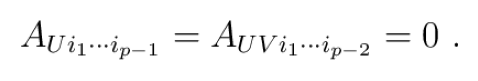

img size: (417, 56)
formula: A_{U i_{1}\cdots i_{p-1}}=A_{U V i_{1}\cdots i_{p-2}}=0~.


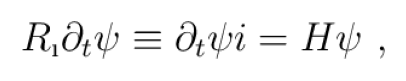

img size: (320, 51)
formula: R_{\i}\partial_{t}\psi\equiv\partial_{t}\psi i=H\psi~,


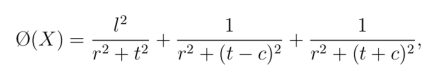

img size: (690, 102)
formula: \O(X)=\frac{\l^{2}}{r^{2}+t^{2}}+\frac{1}{r^{2}+(t-c)^{2}}+\frac{1}{r^{2}+(t+c)^{2}},


In [5]:
draw_random_images(DATASET.joinpath('train', 'images'), DATASET.joinpath('train', 'annotations.json'), nums=3)

### dataset II

В качестве второго датасета возьмем более "сложные" для моделей изображения. Будет уменьшено разрешение, ухудшено качество, добавлены различные шумы и искажения, изменена цветовая палитра.
Второй датасет искусственно получим из первого, применив к каждому изображению случайный набор искажений.

In [156]:
def distortion_img(
    img: Image.Image, 
    transforms_alb: Callable[[Image.Image], Image.Image], 
    transforms_torch: Callable[[Image.Image], Image.Image],
) -> Image.Image:

    #Уменьшаем изображение
    new_size = [int(size / 1.5) for size in img.size]
    img = img.resize(new_size)

    img = np.array(img)
    img = transforms_alb(image=img)['image']

    img = v2.functional.to_image(img)
    img = transforms_torch(img)
    img = v2.functional.to_pil_image(img)
    return img


transforms_alb = A.Compose([
    A.Affine(rotate=(-1, 1), fit_output=True, border_mode=cv2.BORDER_CONSTANT, fill=(255, 255, 255), p=.6),
    A.Perspective(scale=(.001, .01), fit_output=True, fill=(255, 255, 255), p=.4),
    A.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2, p=.25),
    ColorShiftAlb(min_val=.8, p=.8),
    A.ImageCompression(quality_range=(85, 99), p=.4),
    A.GaussNoise(std_range=(.01, .09), p=.2),
    A.GaussianBlur(blur_limit=(1, 3), p=.1),
    ])

transforms_torch=v2.Compose([
    T.RandomApply(T.RandomShadow((0, .3)), p=.3),
])

In [157]:
# edit_images(DATASET / 'test' / 'images', DATASET / 'test' / 'images_dist', distortion_img, transforms_alb, transforms_torch)

  0%|          | 0/10322 [00:00<?, ?it/s]

Посмотрим несколько случайных примеров:

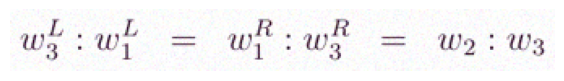

img size: (336, 38)
formula: w_{3}^{L}:w_{1}^{L}\;\;=\;\;w_{1}^{R}:w_{3}^{R}\;\;=\;\;w_{2}:w_{3}


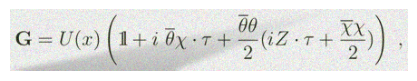

img size: (439, 68)
formula: {\bf G}=U(x)\left(\mathrm{{1}\kern-.25e m\mathrm{l}}+i~\overline{{\theta}}\chi\cdot\tau+{\frac{\overline{{\theta}}\theta}{2}}(i Z\cdot\tau+{\frac{\overline{{\chi}}\chi}{2}})\right)~,


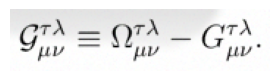

img size: (177, 42)
formula: {\cal G}_{\mu\nu}^{\tau\lambda}\equiv\Omega_{\mu\nu}^{\tau\lambda}-G_{\mu\nu}^{\tau\lambda}.


In [158]:
draw_random_images(DATASET.joinpath('test', 'images_dist'), DATASET.joinpath('test', 'annotations.json'), nums=3)

## Model initialization

Предобученную модель возьмем с Hugging Face: **[Norm/nougat-latex-base](https://huggingface.co/Norm/nougat-latex-base)**.

In [12]:
model_name = "Norm/nougat-latex-base"

model = VisionEncoderDecoderModel.from_pretrained(model_name).to(DEVICE)

tokenizer = NougatTokenizerFast.from_pretrained(model_name)
latex_processor = NougatLaTexProcessor.from_pretrained(model_name)
processor = NougatProcessor(image_processor=latex_processor, tokenizer=tokenizer)

## Torch dataset

In [7]:
# train_transforms = A.Compose([
#     A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.15),
#     A.Compose([
#         A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-.15, 0), rotate_limit=1, 
#                            border_mode=0, interpolation=3, value=(255, 255, 255), p=1),
#         A.GridDistortion(distort_limit=0.1, border_mode=0, interpolation=3, 
#                          value=(255, 255, 255), p=.5)
#     ], p=.15),
#     # A.ElasticTransform(alpha=0.2, sigma=0.1, alpha_affine=0.1, p=.1),
#     A.RandomBrightnessContrast(.1, (-.2, 0), True, p=.2),
#     A.ImageCompression(95, p=.15),
#     # A.GaussNoise(p=.2),
#     # A.GaussianBlur(p=.2)
# ])

In [13]:
# train_set = NougatDataset(
#     DATASET / 'train' / 'images', 
#     DATASET / 'train' / 'annotations.json',
#     processor, 
#     train_transforms
# )

# val_set = NougatDataset(
#     DATASET / 'val' / 'images', 
#     DATASET / 'val' / 'annotations.json',
#     processor, 
# )

test_set = NougatDataset(
    DATASET / 'test' / 'images', 
    DATASET / 'test' / 'annotations.json',
    processor, 
)

test_set2 = NougatDataset(
    DATASET / 'test' / 'images_dist', 
    DATASET / 'test' / 'annotations.json',
    processor, 
)

  0%|          | 0/10280 [00:00<?, ?it/s]

  0%|          | 0/10280 [00:00<?, ?it/s]

Примеры данных из сформированного torch датасета:

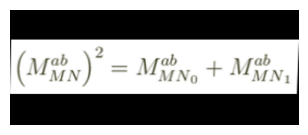

img size: (560, 224)
formula: \left(M_{M N}^{a b}\right)^{2}=M_{{M N}_{0}}^{a b}+M_{{M N}_{1}}^{a b}


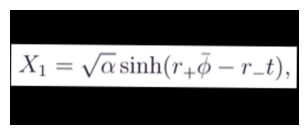

img size: (560, 224)
formula: X_{1}=\sqrt{\alpha}\operatorname{sinh}(r_{+}\bar{\phi}-r_{-}t),


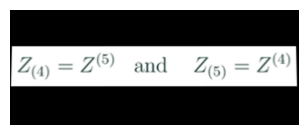

img size: (560, 224)
formula: Z_{(4)}=Z^{(5)}\;\;\;\mathrm{and~}\;\;\;Z_{(5)}=Z^{(4)}


In [47]:
draw_random_images_torchset(test_set2, nums=3)

In [19]:
BATCH_SIZE = 16

# train_loader = DataLoader(
#     train_set,
#     batch_size=BATCH_SIZE,
#     drop_last=True,
#     shuffle=True,
#     pin_memory=IS_CUDA,
#     collate_fn=train_set.collate_fn,
# )

# val_loader = DataLoader(
#     val_set,
#     batch_size=BATCH_SIZE,
#     drop_last=False,
#     shuffle=False,
#     pin_memory=IS_CUDA,
#     collate_fn=val_set.collate_fn,
# )

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False,
    pin_memory=IS_CUDA,
    collate_fn=test_set.collate_fn,
)

test_loader2 = DataLoader(
    test_set2,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False,
    pin_memory=IS_CUDA,
    collate_fn=test_set2.collate_fn,
)

## Train

In [11]:
# parameters = [p for p in model.parameters() if p.requires_grad]
# optimizer = optim.AdamW(parameters, lr=2e-5, eps=1e-6, weight_decay=.05)

In [12]:
# num_epochs = 1

# for epoch in num_epochs:
#     optimizer.zero_grad()

.....................................

## Test

In [22]:
def get_model_outputs(
    model, 
    processor, 
    pixel_values: torch.tensor, 
    decoder_input_ids: torch.tensor, 
    num_beams: str = 5, 
    early_stopping: bool = True
):
    outputs = model.generate(
        pixel_values.to(DEVICE),
        decoder_input_ids=decoder_input_ids.to(DEVICE),
        max_length=model.decoder.config.max_length,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        early_stopping=early_stopping,
        num_beams=num_beams,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    return outputs

In [23]:
def predict_from_pil(
    model, 
    processor, 
    img: Image.Image,
) -> tuple[str, list[int]]:
    """Получение предсказаний модели для одного PIL изображения.

    Returns:
        Предсказанная формула.
    
    """
    pixel_values = processor.image_processor(img, return_tensors="pt").pixel_values

    decoder_input_ids = processor.tokenizer(
        processor.tokenizer.bos_token, 
        add_special_tokens=False,
        return_tensors="pt"
    ).input_ids
    
    model.eval()
    with torch.no_grad():
        outputs = get_model_outputs(model, processor, pixel_values, decoder_input_ids, num_beams=10)

    formula = processor.tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
    tokens = outputs.sequences.cpu()
    # return formula, tokens[0].tolist()
    return formula

### Примеры работы модели

Для каждого изображения из датасета будет отображено:
- исходное изображение
- изображение, отрендеренное по предсказанной формуле
- истинная формула
- предсказанная формула
- если CER > 0, то отобразится строка, в которой будут отмечены различия в формулах:
    - <font color='Red'>красным цветом</font> - добавленные или замененные символы
    - <font color='LightGray'>светло серым цветом</font> - удаленные символы
- метрика CER, вычисленная для формул


#### dataset I

Изображения в хорошем качестве:

Ground truth:


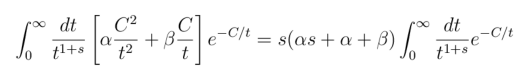

Predict:     


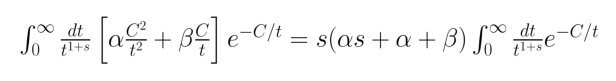


Ground truth: \int_{0}^{\infty}\frac{d t}{t^{1+s}}\left[\alpha\frac{C^{2}}{t^{2}}+\beta\frac{C}{t}\right]e^{-C/t}=s(\alpha s+\alpha+\beta)\int_{0}^{\infty}\frac{d t}{t^{1+s}}e^{-C/t}
Predict:      \int_{0}^{\infty}\frac{d t}{t^{1+s}}\left[\alpha\frac{C^{2}}{t^{2}}+\beta\frac{C}{t}\right]e^{-C/t}=s(\alpha s+\alpha+\beta)\int_{0}^{\infty}\frac{d t}{t^{1+s}}e^{-C/t}

CER: 0.0000
Ground truth:


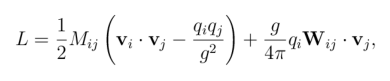

Predict:     


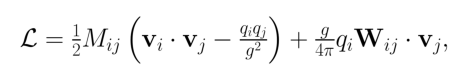


Ground truth: L=\frac{1}{2}M_{i j}\left({\bf v}_{i}\cdot{\bf v}_{j}-{\frac{q_{i}q_{j}}{g^{2}}}\right)+\frac{g}{4\pi}q_{i}{\bf W}_{i j}\cdot{\bf v}_{j},
Predict:      {\cal L}=\frac{1}{2}M_{i j}\left({\bf v}_{i}\cdot{\bf v}_{j}-\frac{q_{i}q_{j}}{g^{2}}\right)+\frac{g}{4\pi}q_{i}{\bf W}_{i j}\cdot{\bf v}_{j},

Difference:   {\cal L}=\frac{1}{2}M_{i j}\left({\bf v}_{i}\cdot{\bf v}_{j}-{\frac{q_{i}q_{j}}{g^{2}}}\right)+\frac{g}{4\pi}q_{i}{\bf W}_{i j}\cdot{\bf v}_{j},

CER: 0.0657
Ground truth:


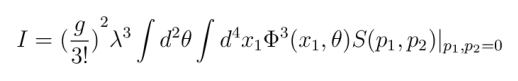

Predict:     


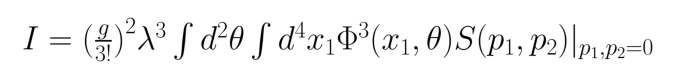


Ground truth: I={\big(\frac{g}{3!}\big)}^{2}\lambda^{3}\int d^{2}\theta\int d^{4}x_{1}\Phi^{3}(x_{1},\theta)S(p_{1},p_{2})|_{p_{1},p_{2}=0}
Predict:      I={(\frac{g}{3!})}^{2}\lambda^{3}\int d^{2}\theta\int d^{4}x_{1}\Phi^{3}(x_{1},\theta)S(p_{1},p_{2})|_{p_{1},p_{2}=0}

Difference:   I={\big(\frac{g}{3!}\big)}^{2}\lambda^{3}\int d^{2}\theta\int d^{4}x_{1}\Phi^{3}(x_{1},\theta)S(p_{1},p_{2})|_{p_{1},p_{2}=0}

CER: 0.0640
Ground truth:


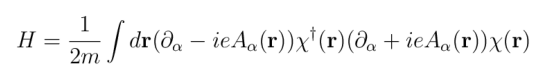

Predict:     


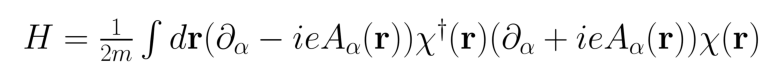


Ground truth: H=\frac{1}{2m}\int d{\bf r}(\partial_{\alpha}-i e A_{\alpha}({\bf r}))\chi^{\dagger}({\bf r})(\partial_{\alpha}+i e A_{\alpha}({\bf r}))\chi({\bf r})
Predict:      H=\frac{1}{2m}\int d{\bf r}(\partial_{\alpha}-i e A_{\alpha}({\bf r}))\chi^{\dagger}({\bf r})(\partial_{\alpha}+i e A_{\alpha}({\bf r}))\chi({\bf r})

CER: 0.0000
Ground truth:


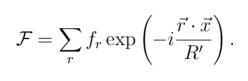

Predict:     


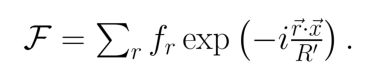


Ground truth: {\cal F}=\sum_{r}f_{r}\operatorname{exp}\left(-i\frac{{\vec{r}}\cdot{\vec{x}}}{R^{\prime}}\right).
Predict:      \mathcal{F}=\sum_{r}f_{r}\exp\left(-i\frac{\vec{r}\cdot\vec{x}}{R^{\prime}}\right).

Difference:   \mathcal{F}=\sum_{r}f_{r}\operatorname{exp}\left(-i\frac{{\vec{r}}\cdot{\vec{x}}}{R^{\prime}}\right).

CER: 0.2449


In [17]:
show_predicts(
    DATASET / 'test' / 'images', 
    DATASET / 'test' / 'annotations.json',
    nums=5,
    predict_from_pil=predict_from_pil,
    model=model, 
    processor=processor, 
)

Стоит отметить, что записать формулу LaTaX можно разными способами, которые дадут один и тот же результат. Вот пару примеров:
| Код | Результат |
| --- | --- |
|`t^{\prime}`, `t'` | $t^{\prime}$, $t'$|
| `\frac{1}{N}`, `\frac1N`, `{1}over{N}` | $\frac{1}{N}$, $\frac1N$, ${1}\over{N}$ |
| `A_{\mu}`, `A_\mu` | $A_{\mu}$, $A_\mu$ |
| `{\rm Tr}`, `\mathrm{Tr}` | ${\rm Tr}$, $\mathrm{Tr}$ |
| `a\ \ \ \ b`, `a\;\;\;\;b`, `a~~~~b`, `a\quad b` | $a\ \ \ \ b$, $a\;\;\;\;b$, $a~~~~b$, $a\quad b$ |


Но саму метрику мы считаем именно по тексту. Поэтому, равноценные с точки зрения визуального отображения записи, могут быть неравноценны с точки зрения записи текстовой. Следовательно, полученная метрика чаще всего будет завышена.  
Что бы от этого избавиться, нужна функция, которая учитывая правила синтаксиса LaTeX, заменит фрагменты, имеющие вариативность в записи на один выбранный вариант. Для еще лучшего эффекта стоит дообучить модель на таких стандартизированных формулах, что бы повысить ее точность.

#### dataset II

Взглянем на примеры работы модели на ухудшенном датасете:

Ground truth:


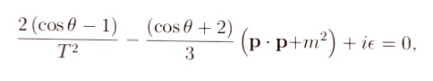

Predict:     


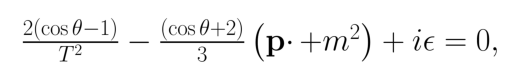


Ground truth: \frac{2\left(\operatorname{cos}\theta-1\right)}{T^{2}}-\frac{\left(\operatorname{cos}\theta+2\right)}3\left(\mathbf{p\cdotp+}m^{2}\right)+i\epsilon=0,
Predict:      \frac{2\left(\cos\theta-1\right)}{T^{2}}-\frac{\left(\cos\theta+2\right)}3\left(\mathbf{p\cdotp+}m^{2}\right)+i\epsilon=0,

Difference:   \frac{2\left(\operatorname{cos}\theta-1\right)}{T^{2}}-\frac{\left(\operatorname{cos}\theta+2\right)}3\left(\mathbf{p\cdotp+}m^{2}\right)+i\epsilon=0,

CER: 0.1867
Ground truth:


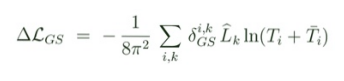

Predict:     


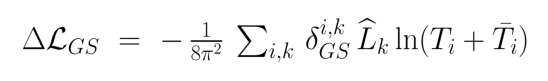


Ground truth: \Delta{\cal L}_{G S}\ =\ -\,\frac{1}{8\pi^{2}}\:\sum_{i,k}\,\delta_{G S}^{i,k}\,\widehat L_{k}\operatorname{ln}(T_{i}+\bar{T}_{i})
Predict:      \Delta{\mathcal L}_{G S}\ =\ -\,\frac{1}{8\pi^{2}}\:\sum_{i,k}\,\delta_{G S}^{i,k}\,\widehat L_{k}\ln(T_{i}+\bar{T}_{i})

Difference:   \Delta{\mathcal L}_{G S}\ =\ -\,\frac{1}{8\pi^{2}}\:\sum_{i,k}\,\delta_{G S}^{i,k}\,\widehat L_{k}\operatorname{ln}(T_{i}+\bar{T}_{i})

CER: 0.1385
Ground truth:


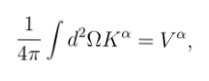

Predict:     


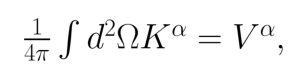


Ground truth: \frac{1}{4\pi}\int d^{2}\Omega K^{\alpha}=V^{\alpha},
Predict:      \frac{1}{4\pi}\int d^{2}\Omega K^{\alpha}=V^{\alpha},

CER: 0.0000


In [160]:
show_predicts(
    DATASET / 'test' / 'images_dist', 
    DATASET / 'test' / 'annotations.json',
    nums=3,
    predict_from_pil=predict_from_pil,
    model=model, 
    processor=processor, 
)

Видно, что с изображениями в плохом качестве модель также справляется неплохо.

### Средняя точность

Теперь посчитаем среднее значение метрики **CER** на 1600 изображениях (100 батчей по 16 картинок).

In [168]:
def evaluate(model, data_loader, processor):
    # acc_token_metric = AccTokenMetric(
    #     pad_token_id=processor.tokenizer.pad_token_id,
    #     eos_token_id=processor.tokenizer.eos_token_id
    # )
    cer_metric = CharErrorRate()
    i = 0
    
    model.eval()
    with torch.no_grad():
        pbar = tqdm(data_loader, leave=False)
        for batch in pbar:
            pixel_values = batch['pixel_values']
            batch_size = pixel_values.shape[0]
            decoder_input_ids = torch.full((batch_size, 1), processor.tokenizer.bos_token_id)
            
            # model predict
            outputs = get_model_outputs(model, processor, pixel_values, decoder_input_ids, num_beams=1, early_stopping=False)
        
            # gt_tokens = batch['input_ids'][:, 1:]
            # pred_tokens = outputs.sequences[:, 1:].cpu()
            # acc_token_metric.add(gt_tokens, pred_tokens)
        
            gt_formulas = batch['formulas']
            pred_formulas = processor.tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)
            cer_metric.update(pred_formulas, gt_formulas)
        
            # pbar_description = f"Accuracy tokens: {acc_token_metric.mean():.4f}, CER formulas: {cer_metric.compute():.4f}"
            pbar_description = f"CER: {cer_metric.compute():.4f}"
            pbar.set_description(pbar_description)

            if i > 100:
                break
            i += 1 

    # return acc_token_metric.mean(), cer_metric.compute()
    return cer_metric.compute()

#### dataset I

In [166]:
cer = evaluate(model, test_loader, processor)
print(f"CER: {Ansi.bold}{cer:.4f}{Ansi.end}")

  0%|          | 0/643 [00:00<?, ?it/s]

CER: 0.1096


#### dataset II

In [169]:
cer = evaluate(model, test_loader2, processor)
print(f"CER: {Ansi.bold}{cer:.4f}{Ansi.end}")

  0%|          | 0/643 [00:00<?, ?it/s]

CER: 0.1371


На качественных изображениях модель в среднем делает **10.96%** ошибок. На более сложных данных ошибается в **13.71%** случаев. Но необходимо помнить о вариативности записи LaTeX формул, которую не учитывает метрика.

## LatexOCR (pix2tex)

В качестве альтернативы рассмотрим модель LatexOCR из библиотеки [pix2tex](https://github.com/lukas-blecher/LaTeX-OCR).

In [2]:
# pip install "pix2tex[gui]"

In [171]:
from pix2tex.cli import LatexOCR
from munch import Munch

In [222]:
conf = Munch({'config': 'settings/config.yaml', 'checkpoint': 'checkpoints/weights.pth', 'no_cuda': not IS_CUDA, 'no_resize': False})
model_pix2tex = LatexOCR(arguments=conf)

/home/lake/anaconda3/envs/lime_test/lib/python3.11/site-packages/pix2tex/cli.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.image_resizer.load_state_dict(torch.lo

### Примеры работы модели

#### dataset I

Ground truth:


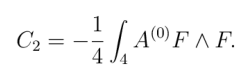

Predict:     


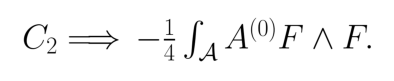


Ground truth: C_{2}=-{\frac{1}{4}}\int_{4}A^{(0)}F\wedge F.
Predict:      C_{2}\Longrightarrow\,-\frac{1}{4}\int_{\cal{A}}A^{(0)}F\wedge F.

Difference:   C_{2}\Longrightarrow\,-\frac{1}{4}}\int_{\cal{A}}A^{(0)}F\wedge F.

CER: 0.5778
Ground truth:


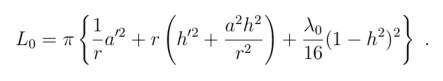

Predict:     


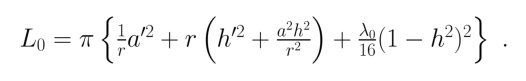


Ground truth: L_{0}=\pi\left\{{\frac{1}{r}}a^{2}+r\left(h^{2}+\frac{a^{2}h^{2}}{r^{2}}\right)+\frac{\lambda_{0}}{16}(1-h^{2})^{2}\right\}\ .
Predict:      L_{0}=\pi\left\{\frac{1}{r}a^{\prime2}+r\left(h^{\prime2}+\frac{a^{2}h^{2}}{r^{2}}\right)+\frac{\lambda_{0}}{16}(1-h^{2})^{2}\right\}\ .

Difference:   L_{0}=\pi\left\{{\frac{1}{r}}a^{\prime2}+r\left(h^{\prime2}+\frac{a^{2}h^{2}}{r^{2}}\right)+\frac{\lambda_{0}}{16}(1-h^{2})^{2}\right\}\ .

CER: 0.1111
Ground truth:


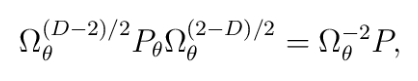

Predict:     


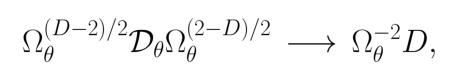


Ground truth: \Omega_{\theta}^{(D-2)/2}{P_{\theta}}\Omega_{\theta}^{(2-D)/2}=\Omega_{\theta}^{-2}P,
Predict:      \Omega_{\theta}^{(D-2)/2}{\cal D}_{\theta}\Omega_{\theta}^{(2-D)/2}\,\longrightarrow\,\Omega_{\theta}^{-2}D,

Difference:   \Omega_{\theta}^{(D-2)/2}{\cal D}_{\theta}}\Omega_{\theta}^{(2-D)/2}\,\longrightarrow\,\Omega_{\theta}^{-2}D,

CER: 0.3294


In [206]:
show_predicts(
    DATASET / 'test' / 'images', 
    DATASET / 'test' / 'annotations.json',
    nums=3,
    predict_from_pil=model_pix2tex,
)

На первый взгляд, данная модель работает менее точно, чем ранее протестированная Norm/nougat-latex-base.

#### dataset II

Ground truth:


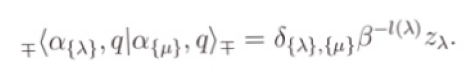

Predict:     


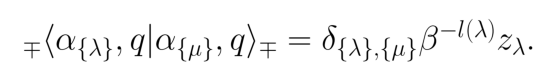


Ground truth: _\mp\langle\alpha_{\{\lambda\}},q|\alpha_{\{\mu\}},q\rangle_{\mp}=\delta_{\{\lambda\},\{\mu\}}\beta^{-l(\lambda)}z_{\lambda}.
Predict:      _\mp\langle\alpha_{\{\lambda\}},q|\alpha_{\{\mu\}},q\rangle_{\mp}=\delta_{\{\lambda\},\{\mu\}}\beta^{-l(\lambda)}z_{\lambda}.

CER: 0.0000
Ground truth:


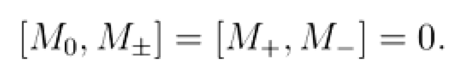

Predict:     


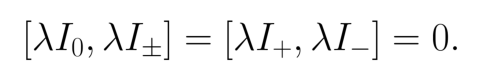


Ground truth: [M_{0},M_{\pm}]=[M_{+},M_{-}]=0.
Predict:      [\lambda I_{0},\lambda I_{\pm}]=[\lambda I_{+},\lambda I_{-}]=0.

Difference:   [\lambda I_{0},\lambda I_{\pm}]=[\lambda I_{+},\lambda I_{-}]=0.

CER: 1.1250
Ground truth:


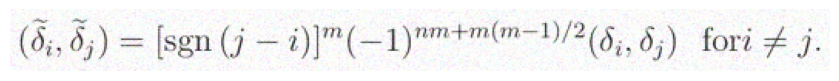

Predict:     


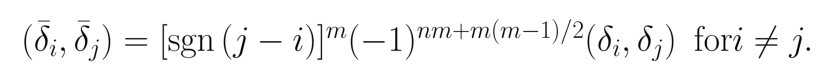


Ground truth: (\widetilde\delta_{i},\widetilde\delta_{j})=[\mathrm{{sgn}}\,(j-i)]^{m}(-1)^{n m+m(m-1)/2}(\delta_{i},\delta_{j})\,\,\,\,\mathrm{for~i\ne~j~.}
Predict:      (\bar{\delta}_{i},\bar{\delta}_{j})=[\mathrm{sgn}\,(j-i)]^{m}(-1)^{n m+m(m-1)/2}(\delta_{i},\delta_{j})\,\ \mathrm{for}i\not=j.

Difference:   (\bar{tilde\delta}_{i},\bar{tilde\delta}_{j})=[\mathrm{{sgn}}\,(j-i)]^{m}(-1)^{n m+m(m-1)/2}(\delta_{i},\delta_{j})\,\_\,\,\mathrm{for}i\not=j~.}

CER: 0.2324


In [216]:
show_predicts(
    DATASET / 'test' / 'images_dist', 
    DATASET / 'test' / 'annotations.json',
    nums=3,
    predict_from_pil=model_pix2tex,
)

Исходя из визуального осмотра нескольких десятков примеров можно сделать предварительный вывод о том, что данная модель несколько чаще ошибается, чем ранее протестированная "Norm/nougat-latex-base".

### Средняя точность

In [217]:
def evaluate_oneattime(model, img_dir: Path, annotations: Path):
    annotations = read_json(annotations)
    img_names = list(annotations.keys())[:1600]

    cer_metric = CharErrorRate()

    pbar = tqdm(img_names, leave=False)
    for img_name in pbar:
        gt_img = Image.open(img_dir.joinpath(img_name))
        gt_formula = annotations[img_name]
        gt_formula = process_raw_latex(gt_formula)

        pred_formula = model(gt_img)

        cer_metric.update(pred_formula, gt_formula)
        pbar_description = f"CER: {cer_metric.compute():.4f}"
        pbar.set_description(pbar_description)

    return cer_metric.compute()

#### dataset I

In [219]:
cer = evaluate_oneattime(
    model_pix2tex,
    DATASET / 'test' / 'images', 
    DATASET / 'test' / 'annotations.json',
)

print(f"CER: {Ansi.bold}{cer:.4f}{Ansi.end}")

  0%|          | 0/1600 [00:00<?, ?it/s]

CER: 0.4398


#### dataset II

In [223]:
cer = evaluate_oneattime(
    model_pix2tex,
    DATASET / 'test' / 'images_dist', 
    DATASET / 'test' / 'annotations.json',
)

print(f"CER: {Ansi.bold}{cer:.4f}{Ansi.end}")

  0%|          | 0/1600 [00:00<?, ?it/s]

CER: 0.3085


Получилась довольно забавная ситуация, на "грязном" датасете LatexOCR показала лучшую точность, чем на качественных изображениях. Возможно, данная модель обучалась на разных наборах данных, и при обучении на "шумных" изображениях текстовый стиль записи формул был больше похож на тот, что представлен в нашем тестовом датасете.

## Summary

Были протестированы две модели **Norm/nougat-latex-base** и **LatexOCR** на двух наборах данных:
- `set I` - изображения хорошего качества
- `set II` - изображения ухудшенного качества

Сводная таблица со средним значением метрики **CER** (процент ошибочно предсказанных символов):
| model | set I | set II |
| --- | --- | --- |
| nougat-latex-base | 10.96% | 13.71% |
| LatexOCR | 43.98% | 30.85% |

**Norm/nougat-latex-base** на обоих датасетах с задачей справилась лучше, как по значению метрики, так и при визуальной оценке отрендеренных формул. Она реже путает символы и в целом довольно точная. Объективно оценить точность метрикой мешает вариативность LaTeX синтаксиса - визуально одинаковые формулы могут быть записаны по разному (более подробно об этом написано выше).  

Если важна только визуальная составляющая, то следует учитывать, что визуальная точность будет лучше, чем значение текущей метрики, для обоих моделей.  
Если важен так же и определенный стиль синтаксиса, то стоит дополнительно обсудить предпочтительные правила, по которым должна быть составлена формула. После чего необходимо будет обновить датасет и перетестировать модели. В случае неудовлетворительного результата можно дообучить лучшую модель для достижения требуемой точности.